# Read h5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal
import DasPrep as dp


# import pyproj


from nptdms import TdmsFile
import DasPrep as idas

# datapath = 'G:\\xfj_das\\'

workpath = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/'
savefigpath = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize_fig/'
# savefigpath_refine = 'D:\\sustech_dir\\workdir\\das-event_reorganize_fig_2\\'
resave_npy_path = '/home/wuzm/data/DAS_DL_Dataset/DASEventData/data/'

save_csv_path = '/home/wuzm/data/DAS_DL_Dataset/DASEventData/phase_picks/'
eq_catalog_file = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/DetectedFinal.dat'

# datapath = '/home/disk/disk02/bluo/xfj_das/'
# das_file = glob.glob(datapath+'*.tdms')
# das_file.sort()

# dp.read_das(das_file[0], metadata='True')

41
(5632, 18000)


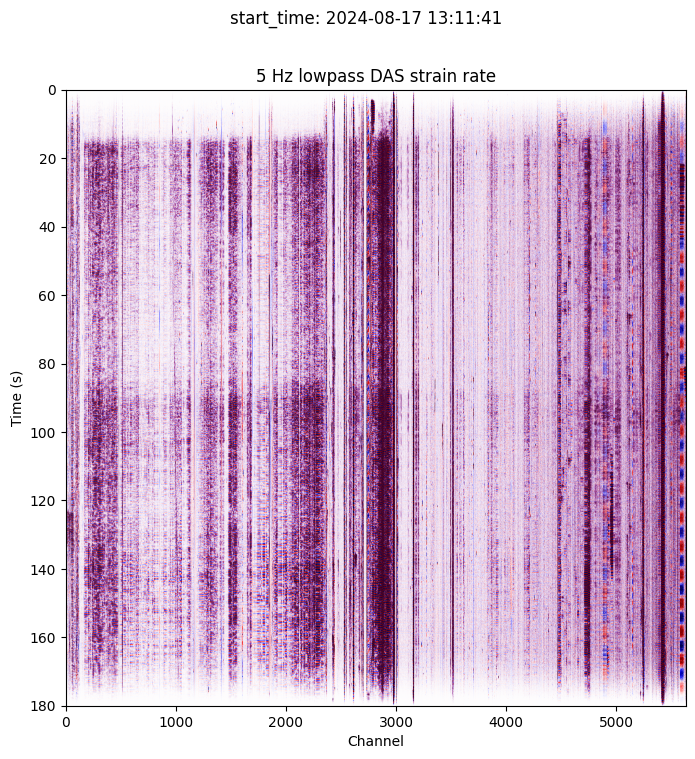

In [ ]:
%matplotlib inline
import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal
import DasPrep as dp
from datetime import datetime, timedelta

eq_name = "宜兰-M4.7-2024-0817T131011"
datapath = "/home/wuzm/data/DAS_DL_Dataset/data/taiwan/Micro_Seis/"+eq_name
flist = glob.glob(datapath+'/*.h5')
flist.sort()
print(len(flist))
for start in range(4, len(flist),4):
# for start in range(1, 2):

    # start = 0
    span = 6
    datalist = []
    for fname in flist[ start : min( start + span , len(flist)) ]:
        # print(fname)
        data = dp.read_das(fname)
        datalist.append(data)
    data_raw = np.concatenate(datalist, axis = 1)
    utc_datetime = datetime.strptime(flist[start][-22 : -7],'%Y%m%d_%H%M%S')
    utc_day = utc_datetime.strftime("%m-%d %H:%M")

    resave_npy_path = "/home/wuzm/data/DAS_DL_Dataset/DASEventData/micro_eq/" + eq_name
    iev = str(start)+'-'+str(start+span)
    resave_name = resave_npy_path + '_100Hz_' + iev + '.npy'

    fq = 400
    dt = 1./400.
    # down sample and save raw data 
    data_raw_d = signal.decimate(data_raw, 4, axis=-1).astype('float32')
    dt *= 4
    fq = 100 
    # np.save(resave_name, data_raw_d.astype('float32'))


    data_raw_d = np.load(resave_name)
    dt = 1./100
    # data process
    data_p = dp.das_preprocess(data_raw_d)
    # f1, f2 = 15, 35
    f1, f2 = 0.01,  5
    # data = dp.bandpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt, fl=f1, fh=f2)
    data = dp.lowpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt,  fh=f2)
    # data = data_p
    print(data.shape)

    # plot hot map to find the arrive time
    # https://stackoverflow.com/questions/39079562/matplotlib-animation-vertical-cursor-line-through-subplots
    fig, ax = plt.subplots(figsize=[8,8])

    clim = data.std() *0.1

    # cum = np.sum(data,axis = 1).reshape(-1,1)
    # data = np.divide(data , cum )
    # print(len(cum))
    ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
            vmin = -clim, vmax = clim,
            extent=[0,data.shape[0], data.shape[1]*dt, 0])

    # ax.set_ylim([5, 1])

    ax.set_xlabel('Channel')
    ax.set_ylabel('Time (s)')
    plt.suptitle( "start_time: " + str( utc_datetime ))
    plt.title(str(f2) + ' Hz lowpass DAS strain rate')
    

    plt.show()
    savefigname = "/home/wuzm/data/DAS_DL_Dataset/data/taiwan/Micro_Seis_fig/" + eq_name+ iev+ '.png'
    fig.savefig(savefigname, dpi=300)



    # fq=100 #采样频率
    # t1 , t2 = 0,180

    # # data_ = data_raw_d[: , int(fq * t1) : int(fq * t2) ]
    # data_tf=np.sum(data_raw_d[1000:2200],axis = 0)  #一维数据
    # print(len(data_tf))
    # t = np.linspace(t1, t2 , num= int(t2-t1) * fq)


    # f, t_, nd = signal.stft(data_tf,fs=fq,window='hann',nperseg= 64,noverlap=None,nfft=None,
    #                     detrend=False,return_onesided=True,boundary='zeros',padded=True,axis=-1)

    # Spg_all = []
    # for i in range(0, len(data_raw_d)):
    #     trace = data_raw_d[i,:] / data_raw_d[i,:].std()
    #     f1, ts, Spg = signal.spectrogram(trace, 1./dt, nperseg=300, noverlap=300*0.9)
    #     Spg_all.append(Spg)
    # Spg_all = np.array(Spg_all).mean(axis=0)



    # fig = plt.figure(figsize=(8, 6))
    # plt.subplot(311)

    # plt.plot(t, data_tf)
    # plt.xlabel("t(s)")
    # plt.xlim(t1,t2)
    # plt.title('STFT',  fontsize=20)
    # plt.subplot(312)

    # plt.pcolormesh(t_+t1, f, np.abs(nd))
    # plt.xlim(t1,t2)
    # # plt.contourf(t_, f,  np.abs(nd),vmax = 200 ,vmin = 0)

    # # plt.ylim([0, min(1./dt/2 , fh)])
    # # plt.title('STFT')
    # plt.ylabel('fq(Hz)')
    # plt.xlabel('time')
    # plt.subplot(313)
    # clim = np.log10(Spg_all).max()
    # plt.imshow(np.log10(Spg_all), aspect='auto', cmap='jet', vmin=-3, vmax=0.5, 
    #         origin='lower', extent=(t1, t2, f1[0], f1[-1]))
    # plt.ylim(0,20)
    # # plt.colorbar()
    # plt.show()
    # savefigname = "/home/wuzm/data/DAS_DL_Dataset/data/taiwan/Micro_Seis_fig/" + eq_name+ iev+ '_fq.png'
    # fig.savefig(savefigname, dpi=300)



# view predict

41
2024-08-22 11:14:24
528.227705882353


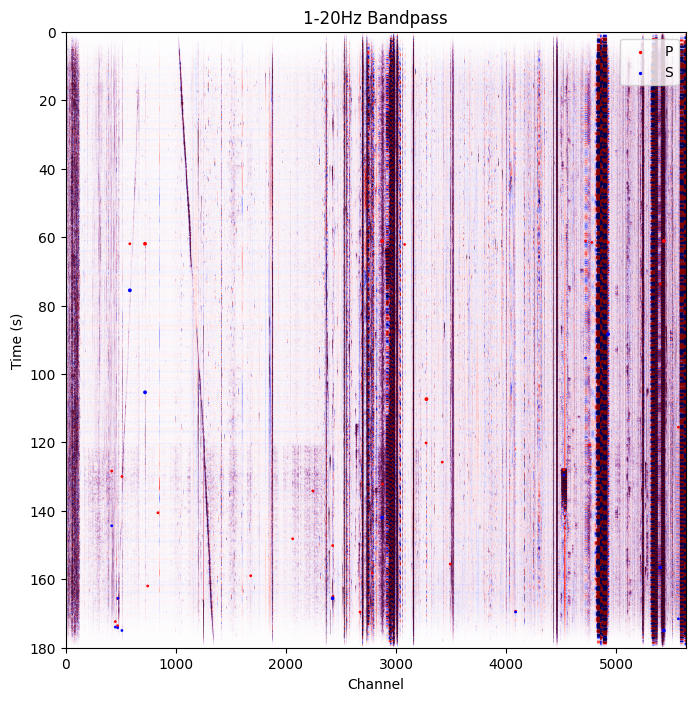

2024-08-22 11:17:24
8479.992411764706


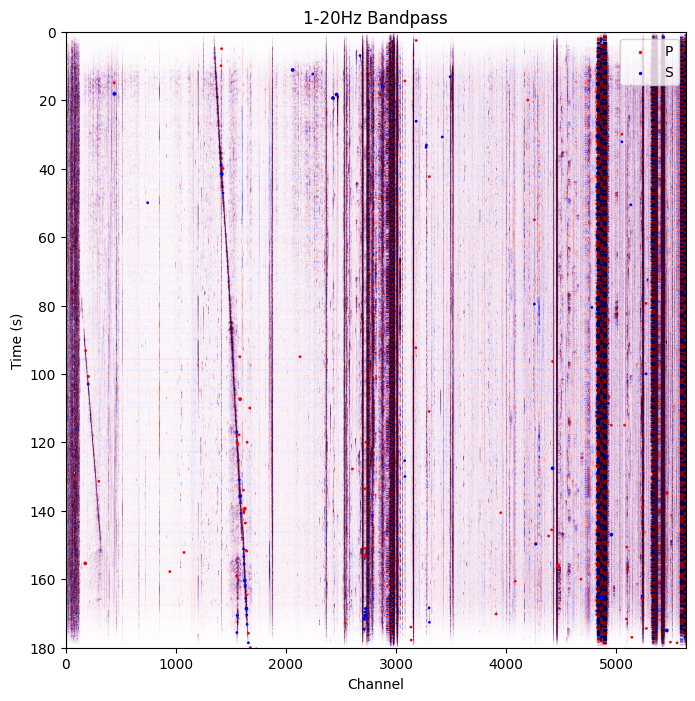

2024-08-22 11:20:24
28883.521823529412


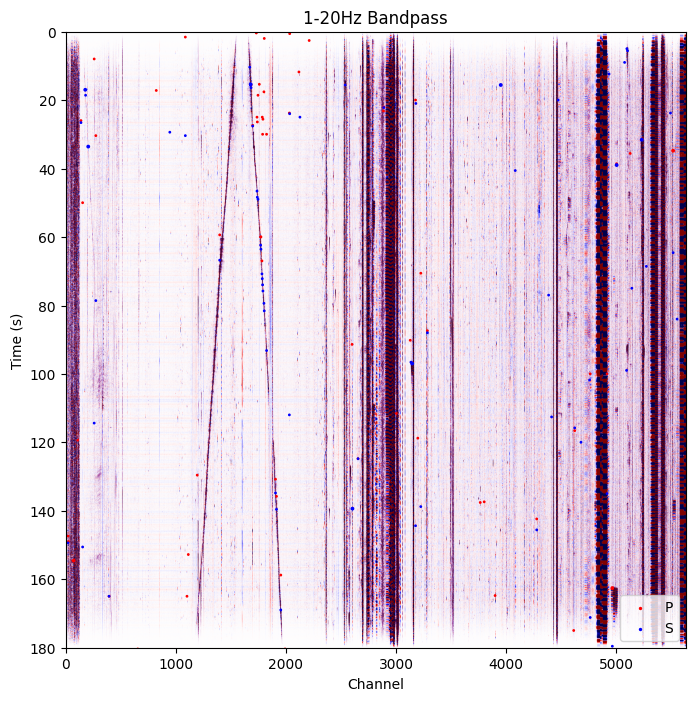

2024-08-22 11:23:24
44204.69829411764


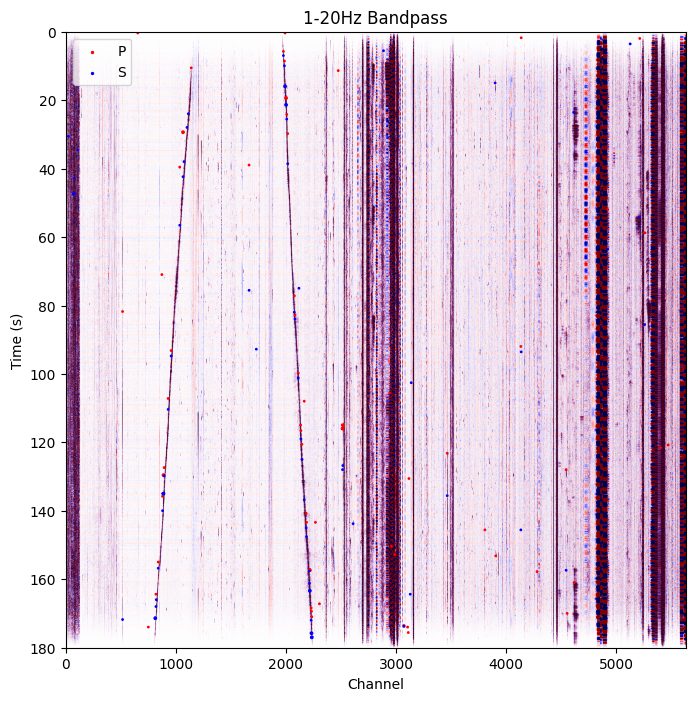

2024-08-22 11:26:24
60542.34535294118


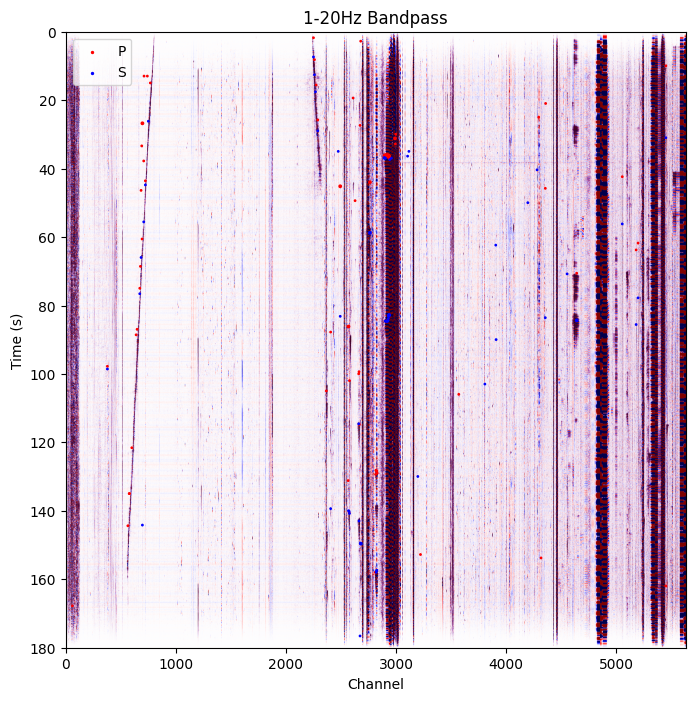

2024-08-22 11:29:24
80183.52182352942


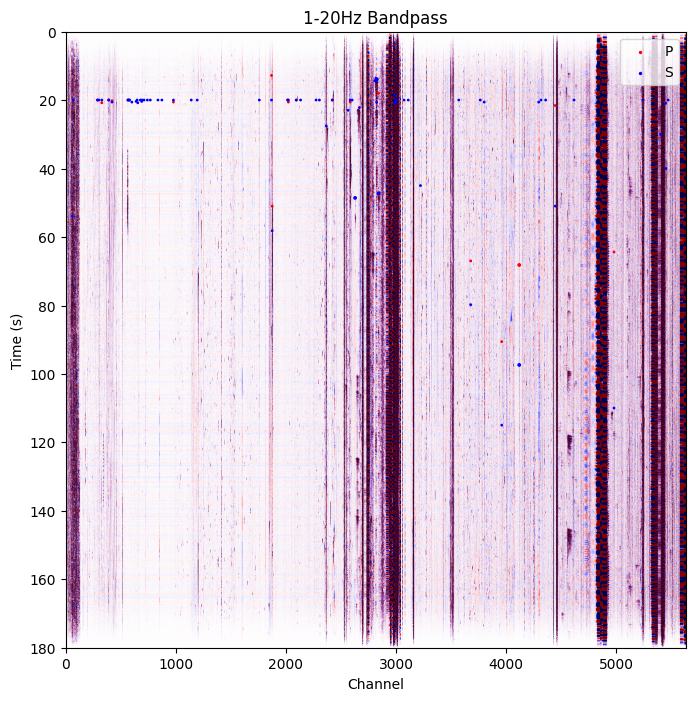

2024-08-22 11:32:24
85848.22770588235


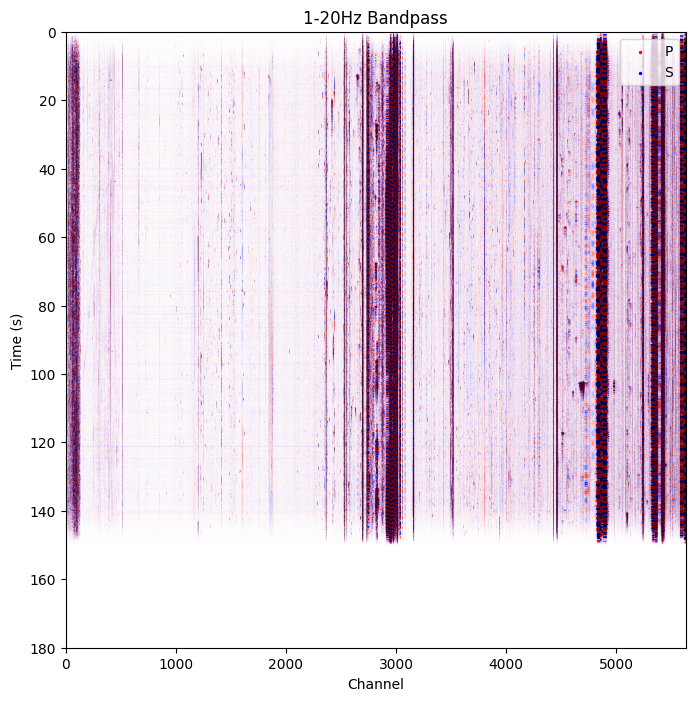

In [7]:
%matplotlib inline
import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal
import DasPrep as dp
from datetime import datetime, timedelta
import glob
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
from scipy import signal
import DasPrep as dp

eq_name = "恒春-M4.6-2024-08-22T111454"
datapath = "/home/wuzm/data/DAS_DL_Dataset/data/taiwan/Micro_Seis/"+eq_name
flist = glob.glob(datapath+'/*.h5')
flist.sort()
print(len(flist))
for start in range(0, len(flist),6):
# for start in range(1, 2):

    # start = 0
       span = 6
       datalist = []
       for fname in flist[ start : min( start + span , len(flist)) ]:
              # print(fname)
              data = dp.read_das(fname)
              datalist.append(data)
       data_raw = np.concatenate(datalist, axis = 1)
       utc_datetime = datetime.strptime(flist[start][-22 : -7],'%Y%m%d_%H%M%S')
       print(utc_datetime)

       resave_npy_path = "/home/wuzm/data/DAS_DL_Dataset/DASEventData/micro_eq/" + eq_name
       iev = str(start)+'-'+str(start+span)
       resave_name = resave_npy_path + '_100Hz_' + iev + '.npy'

       fq = 400
       dt = 1./400.
       # down sample and save raw data 
       data_raw_d = signal.decimate(data_raw, 4, axis=-1).astype('float32')
       dt *= 4
       fq = 100 
       # np.save(resave_name, data_raw_d.astype('float32'))


       # data_raw_d = np.load(resave_name)
       dt = 1./100
       # data process
       data_p = dp.das_preprocess(data_raw_d)
       # f1, f2 = 15, 35
       f1, f2 = 0.01,  5
       # data = dp.bandpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt, fl=f1, fh=f2)
       data = dp.lowpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt,  fh=f2)
       clim = data.std() *0.1


       diting_event = pd.read_csv("/home/disk/disk01/wzm/DAS_DL_Dataset/data/taiwan/sac_diting_5Hz/"+eq_name+"/XFJ.DAS.DiTing0.1B.txt" , sep='\s+',header=None, names=['sta','chn','P0','P1','S0','S1'])


       start_time = utc_datetime
       fig = plt.figure(figsize=[8,8])
       plt.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
              vmin = -clim, vmax = clim,
              extent=[0,data.shape[0], data.shape[1]*dt, 0])
       plt.xlabel('Channel')
       plt.ylabel('Time (s)')
       p_time = np.array([datetime.strptime(diting_event["P0"][i], '%Y-%m-%dT%H:%M:%S.%fZ').__sub__(start_time)
              for i in range(len(diting_event))])
       s_time = np.array([datetime.strptime(diting_event["S0"][i], '%Y-%m-%dT%H:%M:%S.%fZ').__sub__(start_time)
              for i in range(len(diting_event))])
       p_s = np.array([i.seconds + i.microseconds /1000000. for i in p_time])
       s_s = np.array([i.seconds + i.microseconds /1000000. for i in s_time])

       p_c = np.array([3 if i >0.6 else 1 for i in diting_event['P1']])
       s_c = np.array([3 if i >0.6 else 1 for i in diting_event['S1']])

       print(np.mean(p_s))
       plt.scatter(diting_event["chn"].values,p_s, c="r", s=p_c,label = "P")
       plt.scatter(diting_event["chn"].values,s_s, c="b", s=s_c,label = "S")
       # for i in range(len(p_s)):
       #     if np.abs(p_s[i]-np.mean(p_s)) > 10:
       #        if s_c[i]>0:
       #               print(diting_event['S1'][i])
       #               plt.annotate(diting_event['S1'][i], xy = (diting_event["chn"][i], p_s[i]))
       plt.legend()
       # plt.xlabel("Distance (m)")
       # plt.ylabel("Time (s)")
       # plt.ylim(int(np.mean(s_s)+5),int(np.mean(p_s)-5))
       plt.ylim(180,0)

       # arglist = ['Date', 'Time', 'Lat.', 'Lon.', 'Mag.', 'Dep.']
       # plt.text(2050, int(np.mean(p_s)), eq_cat.iloc[iev][arglist])
       plt.title("1-20Hz Bandpass")
       plt.show()

       # savefigname = "/home/disk/disk01/wzm/DAS_DL_Dataset/data/xfj/sac_diting_fig" + 'xfj_das_diting_eq_' + str(iev)+ '.png'
       savefigname = "/home/disk/disk01/wzm/DAS_DL_Dataset/data/taiwan/sac_diting_5hz_fig/" + 'xfj_das_diting_eq_' + str(iev)+ '.png'


       # fig.savefig(savefigname, dpi=300)





data_raw_d = np.load(resave_name)
dt = 1./100
# data process
data_p = dp.das_preprocess(data_raw_d)
# f1, f2 = 15, 35
f1, f2 = 0.01,  5
# data = dp.bandpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt, fl=f1, fh=f2)
data = dp.lowpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt,  fh=f2)
# data = data_p
print(data.shape)

# plot hot map to find the arrive time
# https://stackoverflow.com/questions/39079562/matplotlib-animation-vertical-cursor-line-through-subplots
fig, ax = plt.subplots(figsize=[8,8])

clim = data.std() *0.1

# cum = np.sum(data,axis = 1).reshape(-1,1)
# data = np.divide(data , cum )
# print(len(cum))
ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

# ax.set_ylim([5, 1])

ax.set_xlabel('Channel')
ax.set_ylabel('Time (s)')
plt.text(2050, 53, "start_time: " + utc_datetime)
plt.title(str(f2) + ' Hz lowpass DAS strain rate')

plt.show()
savefigname = "/home/wuzm/data/DAS_DL_Dataset/data/taiwan/Micro_Seis_fig" + '花莲-M6.1-2024-08-15T233553_' + iev+ '.png'
fig.savefig(savefigname, dpi=300)


In [ ]:
print(clim)

das_ch1 , das_ch2 = 500 , 2000

t1 , t2 = 50,65
data2 = data[: , int(fq * t1) : int(fq * t2) ]

# data2 = np.cumsum(data2, axis=1) #计算应变率

def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

def smooth2(a, nx, ny):
    kernel = np.ones((nx,ny)) * 1 / (nx * ny)
    r = signal.convolve2d(a, kernel, mode = 'same')
    return r

data2 = smooth2( data2 , 10 , 1  ) #滑动平均

fig, ax = plt.subplots( figsize=(15,10))

clim = data2.std() *0.1

ax.imshow(data2[das_ch1:das_ch2, :], aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[t1,t2, das_ch2, das_ch1])
# ax.set_ylim(-100, 3200)

# for i in range(das_ch1 , das_ch2 , 1 ):
#     ax.plot(np.linspace(t1 ,  t2  , data2.shape[1] )   , data2[i]/50 + i, 'k', linewidth=0.5)

ax.set_ylabel("#channel")
ax.set_xlabel("time(s)")


# DAS 2 SAC

In [ ]:
from obspy import Stream, Trace
import numpy as np

def das_st_write_sac(das_tr, date_folder_path, write_coordinates=False):
    chn = int(das_tr.stats.location)
    if chn%3 == 0:
        das_tr.stats.channel = 'HHE'
    elif chn%3 == 1:
        das_tr.stats.channel = 'HHN'
    elif chn%3 == 2:
        das_tr.stats.channel = 'HHZ'
    if write_coordinates:
        das_tr.stats.sac = {'stla': das_tr.stats.coordinates['latitude'], 
                      'stlo': das_tr.stats.coordinates['longitude']}
    nw = das_tr.stats.network
    sta = das_tr.stats.station
    
    das_tr.write(date_folder_path + '//'+'xfj_das_re_eq_' + str(iev)+'.'+nw+'.'+sta+'.'+str(chn//3*3)+'.'+das_tr.stats.channel+'.sac', format='SAC') 

dir0 = '/home/disk/disk01/wzm/DAS_DL_Dataset/data/taiwan/Micro_Seis/'
eq_list = np.sort( os.listdir(dir0))

for eq in eq_list:
    dir1 = os.path.join(dir0,eq)
    file_list = [f for f in os.listdir(dir1) if "DPZ" in f]

    sacdirname=[]
    for fname in file_list:
    savename = save_file_name_prefix + str(iev) + '.npy'
    if savename in das_file:
        fq = 300
        dt = 1./300.
        print(savename)
        data_raw = np.load(savename)
        # down sample and save raw data 
        data_raw_d = signal.decimate(data_raw, 3, axis=-1).astype('float32')
        dt *= 3
        fq = 100 
        resave_name = resave_npy_path + 'xfj_das_100Hz_' + str(iev) + '.npy'
        np.save(resave_name, data_raw_d.astype('float32'))



        ch1 = 0
        ch2 = 2944
        das_ch_id = np.arange(ch1, ch2)

        nw = 'xfj'
        sta = 'DAS'
        start_time = eq_time[iev]

        for ich in das_ch_id:
            data_ich = np.where(das_ch_id==ich)[0][0]

            tr = Trace(data=data_raw_d[ich,:], header={'network':nw, 
                                                'station': sta, 
                                                'location':str(data_ich), 
                                                'channel': str(ich),
                                                'starttime':str(start_time), 
                                                'delta':dt})
            
            das_st_write_sac(tr , "/home/disk/disk01/wzm/DAS_DL_Dataset/DASEventData/xfj_sac_data")

            